
## Game N Gen

* python 3.10 


In [1]:

## !pip install torchvision

# Install the 'einops' library for easy manipulation of tensors
## !pip install einops

# Install the 'lpips' library for computing perceptual similarity between images
## !pip install lpips
## !pip install tqdm


In [2]:

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math


In [3]:

torch.cuda.is_available()


True

In [4]:

import condDiffusionTK as condDiff_TK
import UnetTransformer as UnetTransformer


In [5]:

condDiff_obj    = condDiff_TK.condDiffusion()


In [6]:

condDiff_obj.load_MIST()


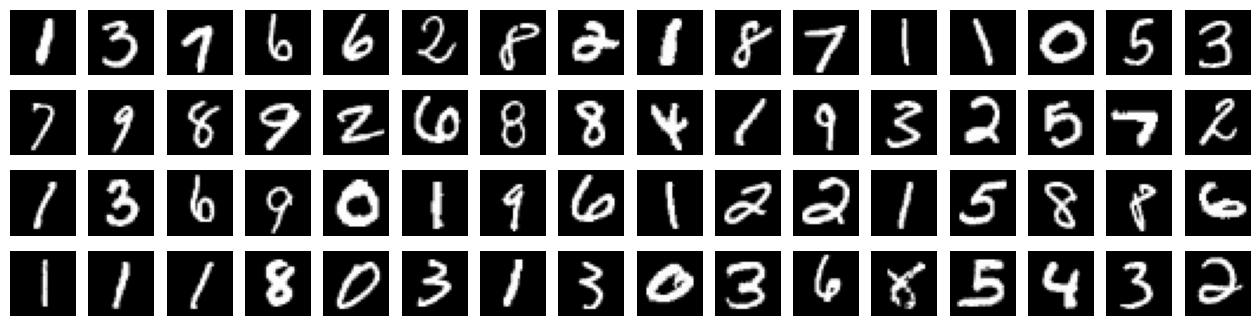

In [7]:

condDiff_obj.my_view_sample_MNIST()


In [8]:

condDiff_obj.init_marginal_prob_diff_coeff()


In [9]:

def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss


In [10]:

continue_training = False ## continue training or initialize a new model

if not continue_training:

    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UnetTransformer.UNet_Tranformer(marginal_prob_std=condDiff_obj.marginal_prob_std_fn))
    score_model = score_model.to(condDiff_obj.device)


batch_size =  1024 #{'type':'integer'}


dataset     = MNIST('.', train=True, transform=condDiff_obj.transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = Adam(score_model.parameters(), lr=condDiff_obj.lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(condDiff_obj.n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    for x, y in tqdm(data_loader):
        x = x.to(condDiff_obj.device)

        loss = loss_fn_cond(score_model, x, y, condDiff_obj.marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=self.device)


0 Average Loss: 1497.680306 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 383.583699 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 271.706234 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 212.764856 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 175.681391 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 150.245069 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 131.165462 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 118.180768 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 106.871639 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 98.662055 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 92.024337 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 86.216327 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 81.315462 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 77.287772 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 73.180537 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 70.065004 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 67.166551 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 64.954118 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 62.915718 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 61.542633 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 59.951296 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 58.443817 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 57.837132 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 56.525931 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 55.301430 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 54.446911 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 53.391088 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 52.672384 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 51.840822 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 51.557443 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 50.851266 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 50.375027 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 49.510366 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 48.906120 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 48.304218 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 48.028549 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 47.660464 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 46.709945 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 46.549105 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 46.138112 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 45.416373 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 45.369206 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 44.797328 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 44.705152 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 44.103636 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 43.963158 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 43.452582 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 42.968938 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 42.707197 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 42.660053 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 42.423918 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 41.845808 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 41.405416 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 40.999864 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 41.326520 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 40.654750 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 40.478151 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 40.411739 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 40.355188 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 39.880839 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 39.701450 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 39.556799 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 39.174541 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 39.421201 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 39.203235 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 39.098758 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 38.786342 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 38.484339 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 38.181110 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 38.526343 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 38.239645 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 38.038144 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 38.213567 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 37.838870 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 37.556154 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 37.643865 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 37.434566 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 36.986778 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 37.333181 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 37.021800 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 36.667660 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 37.022125 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 36.699191 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 36.391215 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 36.525945 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 36.632143 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 36.251868 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 36.217311 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 36.243975 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 36.173135 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 35.838793 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 35.804374 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 35.683026 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 35.762588 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 35.480089 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 35.522144 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 35.369641 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 35.248269 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 35.143626 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 35.029598 lr 2.0e-04


  0%|          | 0/250 [00:00<?, ?it/s]

/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=self.device)


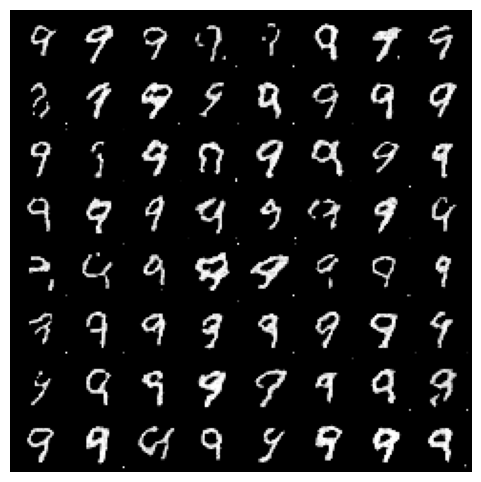

In [11]:

ckpt = torch.load('ckpt_transformer.pth', map_location=condDiff_obj.device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
digit = 9
###########
###########


sample_batch_size = 64
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = condDiff_obj.Euler_Maruyama_sampler # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  condDiff_obj.marginal_prob_std_fn,
                  condDiff_obj.diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=condDiff_obj.device,
                  y=digit*torch.ones(sample_batch_size, dtype=torch.long)
)

############### Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))


plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()


In [12]:

'''

import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def show_images_in_same_spot(images, delay=0.3):
    for img in images:
        clear_output(wait=True)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        display(plt.gcf())
        time.sleep(delay)

images = [torch.rand(28, 28).numpy() for _ in range(30)]

show_images_in_same_spot(images, delay=0.1)

'''


"\n\nimport torch\nimport matplotlib.pyplot as plt\nfrom IPython.display import display, clear_output\nimport time\n\ndef show_images_in_same_spot(images, delay=0.3):\n    for img in images:\n        clear_output(wait=True)\n        plt.imshow(img, cmap='gray', vmin=0, vmax=1)\n        plt.axis('off')\n        display(plt.gcf())\n        time.sleep(delay)\n\nimages = [torch.rand(28, 28).numpy() for _ in range(30)]\n\nshow_images_in_same_spot(images, delay=0.1)\n\n"

In [13]:

'''
combined_cond = torch.cat([prev_img_latent, controller], dim=1)

trajectory = [
    (controller=[1,0,...], image=img1),
    (controller=[0,1,...], image=img2),
    ...
]

'''


'\ncombined_cond = torch.cat([prev_img_latent, controller], dim=1)\n\ntrajectory = [\n    (controller=[1,0,...], image=img1),\n    (controller=[0,1,...], image=img2),\n    ...\n]\n\n'

In [16]:

from IPython.display import HTML
from matplotlib import animation

def animate_images_html(images, interval=100):
    fig, ax = plt.subplots()
    im = ax.imshow(images[0], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    def update(i):
        im.set_array(images[i])
        return [im]

    ani = animation.FuncAnimation(
        fig, update, frames=len(images),
        interval=interval, blit=True, repeat=False
    )
    return HTML(ani.to_jshtml())  # Return HTML animation



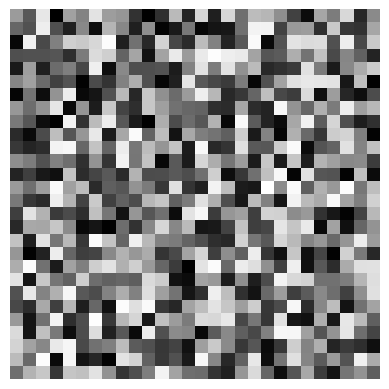

In [17]:

images = [torch.rand(28, 28).numpy() for _ in range(30)]
animate_images_html(images, interval=100)



In [18]:

samples1 = sampler(score_model,
                  condDiff_obj.marginal_prob_std_fn,
                  condDiff_obj.diffusion_coeff_fn,
                  1,          ## batch size
                  num_steps=num_steps,
                  device=condDiff_obj.device,
                  y=digit*torch.ones(sample_batch_size, dtype=torch.long)
)


/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=self.device)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=self.device)


In [19]:

samples1[0].shape


torch.Size([1, 28, 28])

In [20]:

type(samples1[0])


torch.Tensor

In [21]:

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation

def animate_images_with_labels_html(images, labels, interval=100):
    fig, ax = plt.subplots()
    im = ax.imshow(images[0], cmap='gray', vmin=0, vmax=1)
    title = ax.set_title(f"Label: {labels[0]}", fontsize=14)
    ax.axis('off')

    def update(i):
        im.set_array(images[i])
        title.set_text(f"Label: {labels[i]}")
        return [im, title]

    ani = animation.FuncAnimation(
        fig, update, frames=len(images),
        interval=interval, blit=True, repeat=False
    )
    ani.save("anim.gif", writer='pillow')  # Save as GIF
    return HTML(ani.to_jshtml())



In [22]:

import random

images = []
labels = []

for i in range(30):
    digit = random.randint(0, 9)
    samples1 = sampler(score_model,
                  condDiff_obj.marginal_prob_std_fn,
                  condDiff_obj.diffusion_coeff_fn,
                  1,          ## batch size
                  num_steps=num_steps,
                  device=condDiff_obj.device,
                  y=digit*torch.ones(sample_batch_size, dtype=torch.long)
    )
    res = samples1[0].squeeze(0)
    res = res.cpu().numpy() 
    images.append( res ) 
    labels.append( digit )



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

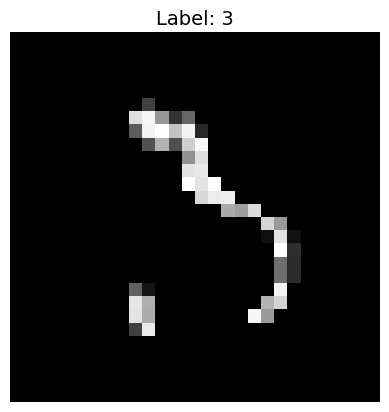

In [23]:

## animate_images_html(images, labels, interval=100)

animate_images_with_labels_html(images, labels, interval=1000)
